<a href="https://colab.research.google.com/github/gauravpks/dl-repo/blob/master/ANN/HyperparameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter tuning with Keras Tuner

In [16]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.0


In [13]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=4b6f814575855fc129a705a7fe90e78b38f4546c89f5fbe53141e16f0a4d1fe5
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=11d3c8e29bfa4d5aec481fda608250d19135649a64eaf716b470e898d5710465
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband

**Hyperparameters**
1. How many number of hidden layers we should have?
2. How many number of neurons we should have in hidden layers?
3. Learning Rate

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [20]:
X_train.shape

(11610, 8)

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

**Function for Building Model**

In [17]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='softplus'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

**Using RandomSearch**

In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Housing')

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [21]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 25s]
val_mean_absolute_error: 0.37122658888498944

Best val_mean_absolute_error So Far: 0.37122658888498944
Total elapsed time: 00h 02m 07s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

Results summary
Results in project/Housing
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 12
units_0: 224
units_1: 352
learning_rate: 0.0001
units_2: 320
units_3: 256
units_4: 320
units_5: 480
units_6: 256
units_7: 288
units_8: 288
units_9: 64
units_10: 480
units_11: 416
units_12: 288
units_13: 32
units_14: 448
units_15: 480
Score: 0.37122658888498944
Trial summary
Hyperparameters:
num_layers: 9
units_0: 224
units_1: 480
learning_rate: 0.0001
units_2: 256
units_3: 480
units_4: 288
units_5: 128
units_6: 288
units_7: 256
units_8: 384
units_9: 64
Score: 0.3745770951112111
Trial summary
Hyperparameters:
num_layers: 16
units_0: 384
units_1: 448
learning_rate: 0.0001
units_2: 128
units_3: 448
units_4: 224
units_5: 160
units_6: 128
units_7: 480
units_8: 192
units_9: 256
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score: 0.3812527259190877
Trial summary
Hyperparameters:
num_layers: 1

In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [24]:
best_model = tuner.get_best_models(num_models=1)[0]

In [25]:
best_model.evaluate(X_train, y_train)

363/363 [==============================] - 1s 2ms/step - loss: 0.3553 - mean_absolute_error: 0.3553


[0.3548550605773926, 0.3548550605773926]

In [26]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history= model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 0.8303 - mean_absolute_error: 0.8303 - val_loss: 0.4213 - val_mean_absolute_error: 0.4213
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4184 - mean_absolute_error: 0.4184 - val_loss: 0.4352 - val_mean_absolute_error: 0.4352
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4059 - mean_absolute_error: 0.4059 - val_loss: 0.3936 - val_mean_absolute_error: 0.3936
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3892 - mean_absolute_error: 0.3892 - val_loss: 0.3691 - val_mean_absolute_error: 0.3691
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3864 - mean_absolute_error: 0.3864 - val_loss: 0.3754 - val_mean_absolute_error: 0.3754
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3666 - mean_absolute_error: 0.3666 - val_loss: 0.3984 - val_mean_absolute_error: 0.3984
Epoch 7/20
363/3

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               2016      
_________________________________________________________________
dense_1 (Dense)              (None, 352)               79200     
_________________________________________________________________
dense_2 (Dense)              (None, 320)               112960    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               82176     
_________________________________________________________________
dense_4 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_5 (Dense)              (None, 480)               154080    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1

In [32]:
history.history

{'loss': [0.5826172828674316,
  0.415357381105423,
  0.39620426297187805,
  0.38424450159072876,
  0.37634938955307007,
  0.3678875267505646,
  0.3664967119693756,
  0.35664066672325134,
  0.35341745615005493,
  0.3489197790622711,
  0.3454658091068268,
  0.3462313711643219,
  0.3383048176765442,
  0.3369063138961792,
  0.33360347151756287,
  0.33200347423553467,
  0.33083128929138184,
  0.3248605728149414,
  0.32662510871887207,
  0.3239026367664337],
 'mean_absolute_error': [0.5826172828674316,
  0.415357381105423,
  0.39620426297187805,
  0.38424450159072876,
  0.37634938955307007,
  0.3678875267505646,
  0.3664967119693756,
  0.35664066672325134,
  0.35341745615005493,
  0.3489197790622711,
  0.3454658091068268,
  0.3462313711643219,
  0.3383048176765442,
  0.3369063138961792,
  0.33360347151756287,
  0.33200347423553467,
  0.33083128929138184,
  0.3248605728149414,
  0.32662510871887207,
  0.3239026367664337],
 'val_loss': [0.4071376621723175,
  0.3920731246471405,
  0.40491190552

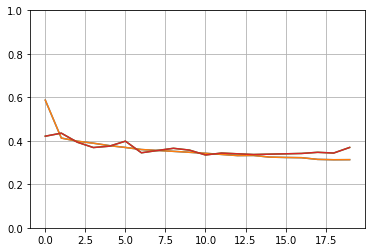

In [28]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [29]:
model.evaluate(X_test,y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3700 - mean_absolute_error: 0.3700


[0.3700443208217621, 0.3700443208217621]

**Using  Hyperband**

Hyperband is an optimized version of random search which uses early-stopping to speed up the hyperparameter tuning process. The main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set. The max_epochs variable is the max number of epochs that a model can be trained for.